حملت ملف زهد

In [5]:
from google.colab import files
uploaded = files.upload()


Saving youtube_standardized.csv to youtube_standardized (2).csv


تاكدت انه متحمل

In [6]:
import os
print(os.listdir())


['.config', 'youtube_standardized (2).csv', 'youtube_standardized (1).csv', 'youtube_standardized.csv', 'sample_data']


تحميل ملف YouTube

In [7]:
import pandas as pd

youtube = pd.read_csv("youtube_standardized.csv")
youtube.head()


,Platform,URL,Engagement,Text,Matched Keywords,toxicity_score,Label,clean_text,word_count,negative_word_count
0,YouTube,https://www.youtube.com/watch?v=Zj1F3HzqnOE,1495,It's weird you're seeing that MAGA will critic...,['hate speech'],0.000737,0,its weird youre seeing that maga will criticiz...,72,1
1,YouTube,https://www.youtube.com/watch?v=Zj1F3HzqnOE,0,"""Were here to save hostages!"" they say bombing...",[],0.028142,0,were here to save hostages they say bombing ev...,22,0
2,YouTube,https://www.youtube.com/watch?v=Zj1F3HzqnOE,0,😂😂 hunting down investigating people in a cha...,[],0.003872,0,hunting down investigating people in a chat ...,12,0
3,YouTube,https://www.youtube.com/watch?v=Zj1F3HzqnOE,0,Epstein files ?,[],0.000680,0,epstein files,2,0
4,YouTube,https://www.youtube.com/watch?v=Zj1F3HzqnOE,0,American Empire is doing a downfall speedrun 😂😂,[],0.002003,0,american empire is doing a downfall speedrun,7,0


In [8]:
# تعديل اسم العمود الخاطئ
youtube.rename(columns={"negative_word_count;;": "negative_word_count"}, inplace=True)

# تحويل الأعمدة النصية إلى رقمية (في YouTube كلها من نوع object)
numeric_cols = ["Engagement", "toxicity_score", "word_count", "negative_word_count"]
for col in numeric_cols:
    if col in youtube.columns:
        youtube[col] = pd.to_numeric(youtube[col], errors='coerce')

# فحص المعلومات العامة
youtube.info()
youtube.describe()
youtube.isna().sum()
youtube.duplicated().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Platform             100 non-null    object 
 1   URL                  100 non-null    object 
 2   Engagement           100 non-null    int64  
 3   Text                 100 non-null    object 
 4   Matched Keywords     100 non-null    object 
 5   toxicity_score       100 non-null    float64
 6   Label                100 non-null    int64  
 7   clean_text           100 non-null    object 
 8   word_count           100 non-null    int64  
 9   negative_word_count  100 non-null    int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 7.9+ KB


np.int64(0)

In [9]:
main_keywords = [
 "hate speech","go back to your country","immigrants","refugees",
 "politicians are corrupt","racism","racial slurs","white supremacy",
 "black people","Asian people","islamophobia","anti-semitism",
 "religious hate","Muslims","Jews","Christians","misogyny"
]

sentiment_keywords = [
 "disgusting","horrible","unacceptable","shameful","evil"
]


In [10]:
# نحذف فقط إذا النص نفسه فاضي
youtube = youtube.dropna(subset=["Text"])

# نملأ باقي القيم المفقودة بصفر أو قيمة منطقية
youtube["Engagement"] = youtube["Engagement"].fillna(0)
youtube["toxicity_score"] = youtube["toxicity_score"].fillna(youtube["toxicity_score"].mean())
youtube["negative_word_count"] = youtube["negative_word_count"].fillna(0)
youtube["Label"] = youtube["Label"].fillna("Unknown")
youtube.head()


,Platform,URL,Engagement,Text,Matched Keywords,toxicity_score,Label,clean_text,word_count,negative_word_count
0,YouTube,https://www.youtube.com/watch?v=Zj1F3HzqnOE,1495,It's weird you're seeing that MAGA will critic...,['hate speech'],0.000737,0,its weird youre seeing that maga will criticiz...,72,1
1,YouTube,https://www.youtube.com/watch?v=Zj1F3HzqnOE,0,"""Were here to save hostages!"" they say bombing...",[],0.028142,0,were here to save hostages they say bombing ev...,22,0
2,YouTube,https://www.youtube.com/watch?v=Zj1F3HzqnOE,0,😂😂 hunting down investigating people in a cha...,[],0.003872,0,hunting down investigating people in a chat ...,12,0
3,YouTube,https://www.youtube.com/watch?v=Zj1F3HzqnOE,0,Epstein files ?,[],0.000680,0,epstein files,2,0
4,YouTube,https://www.youtube.com/watch?v=Zj1F3HzqnOE,0,American Empire is doing a downfall speedrun 😂😂,[],0.002003,0,american empire is doing a downfall speedrun,7,0


In [11]:
youtube = youtube.drop_duplicates(subset=["Text", "URL"])


In [12]:
import re

def clean_text_func(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)          # إزالة الروابط
    text = re.sub(r"[@#]\w+", "", text)          # إزالة المنشن والهاشتاقات
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)   # إزالة الرموز الغريبة
    text = re.sub(r"\s+", " ", text).strip()     # إزالة الفراغات الزائدة
    return text

youtube["clean_text"] = youtube["Text"].apply(clean_text_func)

def find_matched_keywords(text):
    text = str(text).lower()
    matched = [kw for kw in main_keywords + sentiment_keywords if kw in text]
    return matched if matched else None

youtube["Matched Keywords"] = youtube["clean_text"].apply(find_matched_keywords)
youtube.head()


,Platform,URL,Engagement,Text,Matched Keywords,toxicity_score,Label,clean_text,word_count,negative_word_count
0,YouTube,https://www.youtube.com/watch?v=Zj1F3HzqnOE,1495,It's weird you're seeing that MAGA will critic...,[hate speech],0.000737,0,its weird youre seeing that maga will criticiz...,72,1
1,YouTube,https://www.youtube.com/watch?v=Zj1F3HzqnOE,0,"""Were here to save hostages!"" they say bombing...",None,0.028142,0,were here to save hostages they say bombing ev...,22,0
2,YouTube,https://www.youtube.com/watch?v=Zj1F3HzqnOE,0,😂😂 hunting down investigating people in a cha...,None,0.003872,0,hunting down investigating people in a chat in...,12,0
3,YouTube,https://www.youtube.com/watch?v=Zj1F3HzqnOE,0,Epstein files ?,None,0.000680,0,epstein files,2,0
4,YouTube,https://www.youtube.com/watch?v=Zj1F3HzqnOE,0,American Empire is doing a downfall speedrun 😂😂,None,0.002003,0,american empire is doing a downfall speedrun,7,0


In [13]:
# Encoding
youtube["Label"] = youtube["Label"].replace({
    "Hate": 1, "hate": 1, "Hate Speech": 1,
    "Non-Hate": 0, "non hate": 0, "Not Hate": 0,
    "Neutral": 0, "Unknown": 0
})
youtube.head()


,Platform,URL,Engagement,Text,Matched Keywords,toxicity_score,Label,clean_text,word_count,negative_word_count
0,YouTube,https://www.youtube.com/watch?v=Zj1F3HzqnOE,1495,It's weird you're seeing that MAGA will critic...,[hate speech],0.000737,0,its weird youre seeing that maga will criticiz...,72,1
1,YouTube,https://www.youtube.com/watch?v=Zj1F3HzqnOE,0,"""Were here to save hostages!"" they say bombing...",None,0.028142,0,were here to save hostages they say bombing ev...,22,0
2,YouTube,https://www.youtube.com/watch?v=Zj1F3HzqnOE,0,😂😂 hunting down investigating people in a cha...,None,0.003872,0,hunting down investigating people in a chat in...,12,0
3,YouTube,https://www.youtube.com/watch?v=Zj1F3HzqnOE,0,Epstein files ?,None,0.000680,0,epstein files,2,0
4,YouTube,https://www.youtube.com/watch?v=Zj1F3HzqnOE,0,American Empire is doing a downfall speedrun 😂😂,None,0.002003,0,american empire is doing a downfall speedrun,7,0


In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
num_cols = ["Engagement", "toxicity_score", "word_count", "negative_word_count"]
existing_cols = [c for c in num_cols if c in youtube.columns]
youtube[existing_cols] = scaler.fit_transform(youtube[existing_cols])


In [15]:
youtube = youtube[(youtube["word_count"] > 0) & (youtube["word_count"] < 300)]


In [16]:
summary = {
    "final_shape": youtube.shape,
    "missing_values_after": youtube.isna().sum().to_dict(),
    "duplicates_after": youtube.duplicated(subset=["Text", "URL"]).sum(),
}
summary


{'final_shape': (99, 10),
 'missing_values_after': {'Platform': 0,
  'URL': 0,
  'Engagement': 0,
  'Text': 0,
  'Matched Keywords': 90,
  'toxicity_score': 0,
  'Label': 0,
  'clean_text': 0,
  'word_count': 0,
  'negative_word_count': 0},
 'duplicates_after': np.int64(0)}

In [17]:
youtube.to_csv("youtube_cleaned.csv", index=False)


In [18]:
# ---------------------------------------------------
# 🧩 STEP 1: Import Libraries and Load the Data
# ---------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# تحميل البيانات المنظّفة
df = pd.read_csv("youtube_cleaned.csv")

# عرض أول 5 صفوف للتأكد من التحميل
print("🔹 First 5 rows:")
print(df.head())


🔹 First 5 rows:
  Platform                                          URL  Engagement  \
0  YouTube  https://www.youtube.com/watch?v=Zj1F3HzqnOE         1.0   
1  YouTube  https://www.youtube.com/watch?v=Zj1F3HzqnOE         0.0   
2  YouTube  https://www.youtube.com/watch?v=Zj1F3HzqnOE         0.0   
3  YouTube  https://www.youtube.com/watch?v=Zj1F3HzqnOE         0.0   
4  YouTube  https://www.youtube.com/watch?v=Zj1F3HzqnOE         0.0   

                                                Text Matched Keywords  \
0  It's weird you're seeing that MAGA will critic...  ['hate speech']   
1  "Were here to save hostages!" they say bombing...              NaN   
2  😂😂 hunting down  investigating people in a cha...              NaN   
3                                    Epstein files ?              NaN   
4    American Empire is doing a downfall speedrun 😂😂              NaN   

   toxicity_score  Label                                         clean_text  \
0        0.000143      0  its weird you

In [19]:
# ---------------------------------------------------
# 📊 STEP 2: Basic Overview (Getting to Know the Data)
# ---------------------------------------------------
print("\n📘 Dataset Info:")
df.info()

print("\n📏 Dataset Shape:", df.shape)
print("\n📋 Column Names:", list(df.columns))



📘 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Platform             99 non-null     object 
 1   URL                  99 non-null     object 
 2   Engagement           99 non-null     float64
 3   Text                 99 non-null     object 
 4   Matched Keywords     9 non-null      object 
 5   toxicity_score       99 non-null     float64
 6   Label                99 non-null     int64  
 7   clean_text           99 non-null     object 
 8   word_count           99 non-null     float64
 9   negative_word_count  99 non-null     float64
dtypes: float64(4), int64(1), object(5)
memory usage: 7.9+ KB

📏 Dataset Shape: (99, 10)

📋 Column Names: ['Platform', 'URL', 'Engagement', 'Text', 'Matched Keywords', 'toxicity_score', 'Label', 'clean_text', 'word_count', 'negative_word_count']


In [20]:
# ---------------------------------------------------
# 📈 STEP 3: Descriptive Statistics (Non-Graphical Univariate EDA)
# ---------------------------------------------------
print("\n📊 Summary Statistics for Numerical Columns:")
print(df.describe())

print("\n📊 Value Counts for Label Column:")
print(df["Label"].value_counts())



📊 Summary Statistics for Numerical Columns:
       Engagement  toxicity_score      Label  word_count  negative_word_count
count   99.000000       99.000000  99.000000   99.000000            99.000000
mean     0.010331        0.216581   0.202020    0.092788             0.070707
std      0.100482        0.340205   0.403551    0.116801             0.202158
min      0.000000        0.000000   0.000000    0.003049             0.000000
25%      0.000000        0.000986   0.000000    0.038110             0.000000
50%      0.000000        0.012916   0.000000    0.060976             0.000000
75%      0.000669        0.353715   0.000000    0.117378             0.000000
max      1.000000        1.000000   1.000000    1.000000             1.000000

📊 Value Counts for Label Column:
Label
0    79
1    20
Name: count, dtype: int64


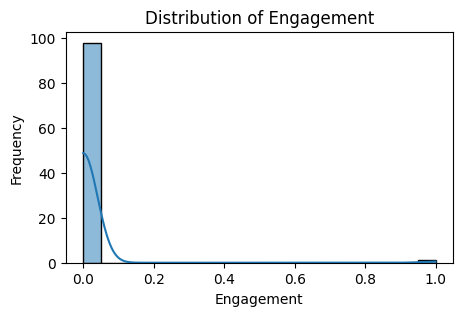

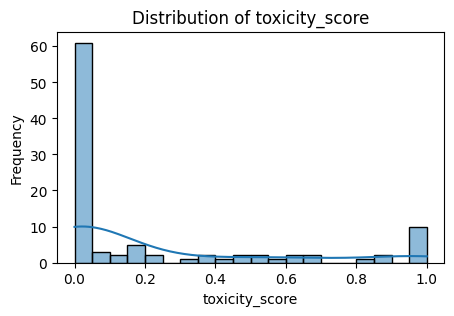

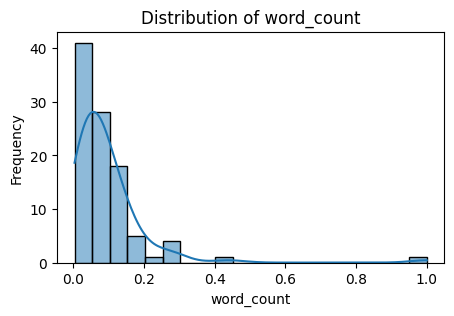

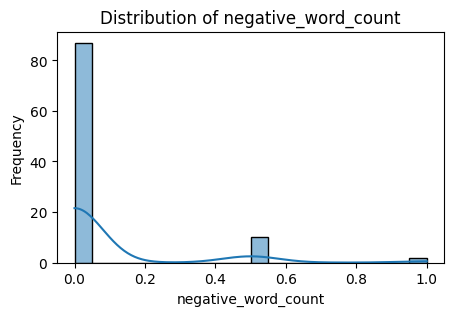

In [21]:
# ---------------------------------------------------
# 🎨 STEP 4: Visualize Numeric Distributions (Histograms)
# ---------------------------------------------------
numeric_cols = ["Engagement", "toxicity_score", "word_count", "negative_word_count"]

for col in numeric_cols:
    if col in df.columns:
        plt.figure(figsize=(5,3))
        sns.histplot(df[col], bins=20, kde=True)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.show()


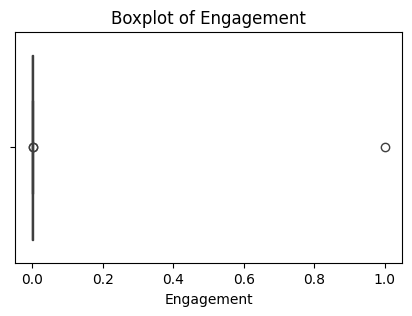

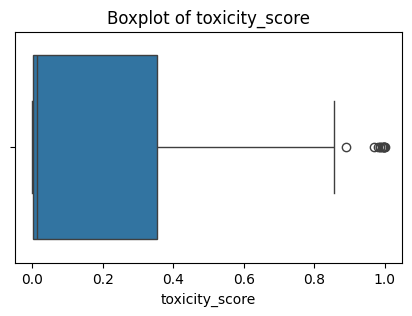

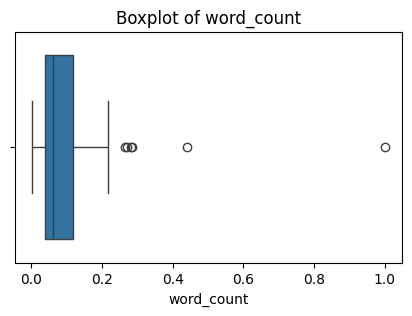

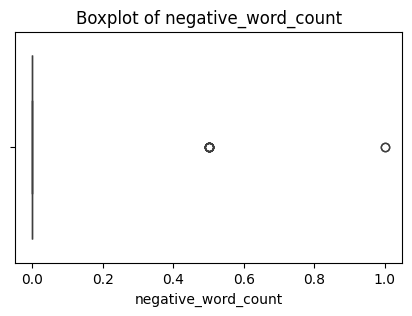

In [22]:
# ---------------------------------------------------
# 📦 STEP 5: Detect Outliers (Boxplots)
# ---------------------------------------------------
for col in numeric_cols:
    if col in df.columns:
        plt.figure(figsize=(5,3))
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot of {col}")
        plt.show()


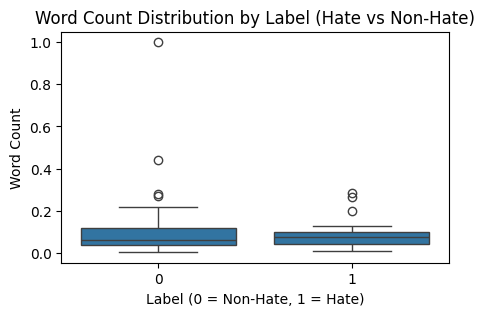

In [23]:
# ---------------------------------------------------
# ⚖️ STEP 6: Categorical vs Quantitative (Boxplot by Label)
# ---------------------------------------------------
if "word_count" in df.columns:
    plt.figure(figsize=(5,3))
    sns.boxplot(x='Label', y='word_count', data=df)
    plt.title("Word Count Distribution by Label (Hate vs Non-Hate)")
    plt.xlabel("Label (0 = Non-Hate, 1 = Hate)")
    plt.ylabel("Word Count")
    plt.show()


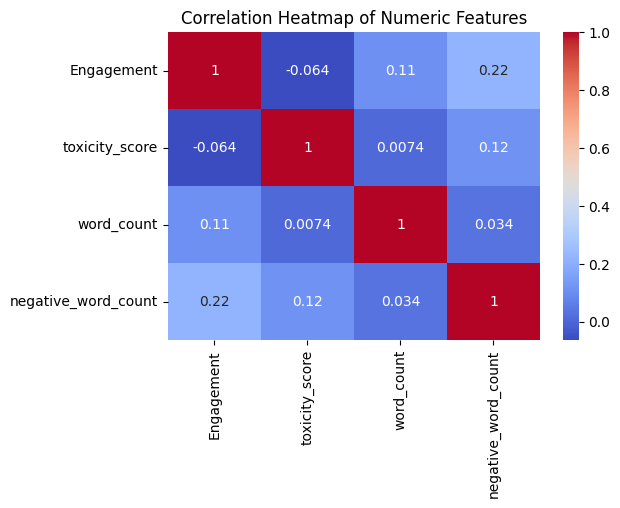

In [24]:
# ---------------------------------------------------
# 🔗 STEP 7: Correlation Analysis (Bivariate EDA)
# ---------------------------------------------------
existing_cols = [c for c in numeric_cols if c in df.columns]
plt.figure(figsize=(6,4))
sns.heatmap(df[existing_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


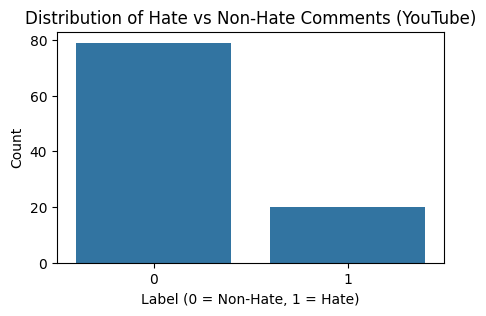

In [25]:
# ---------------------------------------------------
# 📊 STEP 8: Label Distribution Visualization
# ---------------------------------------------------
plt.figure(figsize=(5,3))
sns.countplot(x="Label", data=df)
plt.title("Distribution of Hate vs Non-Hate Comments (YouTube)")
plt.xlabel("Label (0 = Non-Hate, 1 = Hate)")
plt.ylabel("Count")
plt.show()
